In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import datetime as dt

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
all_units=pd.read_parquet(npc_lims.get_cache_path('units',version='0.0.265'))

In [3]:
all_units.columns

Index(['activity_drift', 'amplitude', 'amplitude_cutoff',
       'amplitude_cv_median', 'amplitude_cv_range', 'amplitude_median',
       'ccf_ap', 'ccf_dv', 'ccf_ml', 'channels', 'cluster_id', 'd_prime',
       'decoder_label', 'decoder_probability', 'default_qc', 'drift_mad',
       'drift_ptp', 'drift_std', 'electrode_group_name', 'exp_decay',
       'firing_range', 'firing_rate', 'half_width', 'is_not_drift',
       'isi_violations_count', 'isi_violations_ratio', 'isolation_distance',
       'l_ratio', 'location', 'nn_hit_rate', 'nn_miss_rate',
       'num_negative_peaks', 'num_positive_peaks', 'num_spikes',
       'peak_channel', 'peak_electrode', 'peak_to_valley', 'peak_trough_ratio',
       'peak_waveform_index', 'presence_ratio', 'recovery_slope',
       'repolarization_slope', 'rp_contamination', 'rp_violations',
       'silhouette', 'sliding_rp_violation', 'snr', 'spread', 'structure',
       'unit_id', 'velocity_above', 'velocity_below', 'obs_intervals',
       'electrodes', 

In [125]:
all_units['structure'].unique()

array(['ACAd', 'ACAv', 'CA1', 'CA3', 'DG', 'IG', 'LSr', 'MOs', 'TEa',
       'VISl', 'VISli', 'VISp', 'out of brain', 'AD', 'AUDd', 'DP', 'ILA',
       'MB', 'MOp', 'NB', 'OLF', 'ORBm', 'PL', 'POST', 'RSPagl', 'RSPd',
       'RSPv', 'SSs', 'TTd', 'VISal', 'VL', 'CP', 'FRP', 'HPF', 'ORBl',
       'ORBvl', 'SSp', 'SUB', 'root', 'AUDp', 'AUDpo', 'IGL', 'IntG',
       'LD', 'LGd', 'LGv', 'LP', 'PO', 'STR', 'TH', 'VISpm', 'VPM', 'ZI',
       'or', 'ICe', 'ProS', 'SCig', 'PoT', 'SGN', 'VISam', 'CA2', 'MRN',
       'SEZ', 'MGd', 'MGv', 'BST', 'Eth', 'fa', 'VISa', 'VISrl', 'ACB',
       'AId', 'AIv', 'PAL', 'PIR', 'APN', 'DT', 'LSc', 'LSv', 'POL',
       'SCiw', 'SCop', 'SCsg', 'SCzo', 'SF', 'cing', 'MGm', 'alv', 'LA',
       'SCdg', 'undefined', 'CL', None, 'V3', 'bsc', 'RT', 'AV', 'ccb',
       'scwm', 'ccg', 'CUN', 'ICd', 'PPN', 'PRE', 'SAG', 'VISpor', 'VPL',
       'fp', 'TRS', 'int', 'GPe', 'RN', 'PIL', 'SNr', 'PP', 'MS', 'VAL',
       'HY', 'PAG', 'SCdw', 'VM', 'EPd', 'GPi', 'MEA', 'OT',

In [4]:
len(all_units['session_id'].unique())

248

In [ ]:
general_areas=["CTXpl","OLF","HPF","CTXsp","STR","PAL","TH","HY","MB","HB","P","MY","CB","VL","SEZ",]

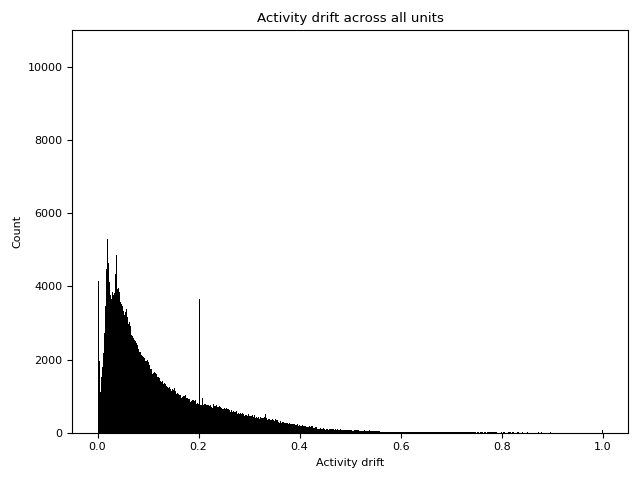

In [5]:
fig,ax=plt.subplots()
ax.hist(all_units['activity_drift'],bins=np.arange(0,1.001,0.001),color='k')
ax.set_title('Activity drift across all units')
ax.set_xlabel('Activity drift')
ax.set_ylabel('Count')
fig.tight_layout()

In [ ]:
no_drift_criteria_frac=len(all_units.query('decoder_label!="noise" and isi_violations_ratio<=0.5 and amplitude_cutoff<=0.1 and presence_ratio>=0.7'))/len(all_units)
print(f'Fraction of units passing basic criteria: {no_drift_criteria_frac:.2f}')

loose_drift_criteria_frac=len(all_units.query('activity_drift<=0.2 and decoder_label!="noise" and isi_violations_ratio<=0.5 and amplitude_cutoff<=0.1 and presence_ratio>=0.7'))/len(all_units)
print(f'Fraction of units passing loose drift criteria (<=0.2): {loose_drift_criteria_frac:.2f}')

medium_drift_criteria_frac=len(all_units.query('activity_drift<=0.15 and decoder_label!="noise" and isi_violations_ratio<=0.5 and amplitude_cutoff<=0.1 and presence_ratio>=0.7'))/len(all_units)
print(f'Fraction of units passing medium drift criteria (<=0.15): {medium_drift_criteria_frac:.2f}')

strict_drift_criteria_frac=len(all_units.query('activity_drift<=0.1 and decoder_label!="noise" and isi_violations_ratio<=0.5 and amplitude_cutoff<=0.1 and presence_ratio>=0.7'))/len(all_units)
print(f'Fraction of units passing strict drift criteria (<=0.1): {strict_drift_criteria_frac:.2f}')

Fraction of units passing basic criteria: 0.62
Fraction of units passing loose drift criteria (<=0.2): 0.58
Fraction of units passing medium drift criteria (<=0.15): 0.52
Fraction of units passing strict drift criteria (<=0.1): 0.42


In [63]:
session_units=all_units.query('session_id=="712815_2024-05-23"')

session_units.query('structure=="MRN"')

,activity_drift,amplitude,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,ccf_ap,ccf_dv,ccf_ml,channels,...,unit_id,velocity_above,velocity_below,obs_intervals,electrodes,device_name,session_idx,date,subject_id,session_id
id,,,,,,,,,,,,,,,,,,,,,
764,NaN,330.479973,NaN,NaN,NaN,25.74000,8300.0,4200.0,5050.0,"[168, 169, 170, 171, 172, 173, 174, 175, 176, ...",...,712815_2024-05-23_F-212,NaN,NaN,"[[20.22250045132084, 7006.50471561544]]","[936, 937, 938, 939, 940, 941, 942, 943, 944, ...",19192715251,0,2024-05-23,712815,712815_2024-05-23
684,0.251515,198.633301,0.000004,NaN,NaN,119.34000,8150.0,3550.0,4800.0,"[244, 245, 246, 247, 248, 249, 250, 251, 252, ...",...,712815_2024-05-23_F-125,NaN,NaN,"[[20.22250045132084, 7006.50471561544]]","[1012, 1013, 1014, 1015, 1016, 1017, 1018, 101...",19192715251,0,2024-05-23,712815,712815_2024-05-23
683,0.262748,157.074848,0.000060,NaN,NaN,65.52000,8150.0,3575.0,4800.0,"[238, 239, 240, 241, 242, 243, 244, 245, 246, ...",...,712815_2024-05-23_F-124,NaN,NaN,"[[20.22250045132084, 7006.50471561544]]","[1006, 1007, 1008, 1009, 1010, 1011, 1012, 101...",19192715251,0,2024-05-23,712815,712815_2024-05-23
679,0.196615,399.189941,0.000024,0.129070,0.063484,243.35999,8150.0,3600.0,4800.0,"[238, 239, 240, 241, 242, 243, 244, 245, 246, ...",...,712815_2024-05-23_F-120,NaN,572.766005,"[[20.22250045132084, 7006.50471561544]]","[1006, 1007, 1008, 1009, 1010, 1011, 1012, 101...",19192715251,0,2024-05-23,712815,712815_2024-05-23
681,0.224192,218.336044,0.000005,0.183725,0.094210,145.08000,8150.0,3600.0,4800.0,"[238, 239, 240, 241, 242, 243, 244, 245, 246, ...",...,712815_2024-05-23_F-122,NaN,207.190077,"[[20.22250045132084, 7006.50471561544]]","[1006, 1007, 1008, 1009, 1010, 1011, 1012, 101...",19192715251,0,2024-05-23,712815,712815_2024-05-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.000000,261.441788,NaN,NaN,NaN,79.56000,8300.0,4200.0,5050.0,"[168, 169, 170, 171, 172, 173, 174, 175, 176, ...",...,712815_2024-05-23_F-70,NaN,NaN,"[[20.22250045132084, 7006.50471561544]]","[936, 937, 938, 939, 940, 941, 942, 943, 944, ...",19192715251,0,2024-05-23,712815,712815_2024-05-23
636,0.386458,205.147736,0.000007,NaN,NaN,154.43999,8300.0,4250.0,5050.0,"[160, 161, 162, 163, 164, 165, 166, 167, 168, ...",...,712815_2024-05-23_F-72,NaN,NaN,"[[20.22250045132084, 7006.50471561544]]","[928, 929, 930, 931, 932, 933, 934, 935, 936, ...",19192715251,0,2024-05-23,712815,712815_2024-05-23
637,0.239513,222.885025,0.000015,NaN,NaN,65.52000,8300.0,4250.0,5050.0,"[162, 163, 164, 165, 166, 167, 168, 169, 170, ...",...,712815_2024-05-23_F-73,NaN,NaN,"[[20.22250045132084, 7006.50471561544]]","[930, 931, 932, 933, 934, 935, 936, 937, 938, ...",19192715251,0,2024-05-23,712815,712815_2024-05-23


In [117]:
drift_by_session={
    'session_id':[],
    'date':[],
    'activity_drift':[],
    'presence_ratio':[],
    'isi_violations_ratio':[],
    'amplitude_cutoff':[],
    'fraction_sua':[],
    'fraction_mua':[],
    'fraction_noise':[],
    'n_total_units':[],
    'n_good_blocks':[],
    'overall_dprime':[],
}

sel_area='CP'

all_sessions=all_units['session_id'].unique()
for session_id in all_sessions:
    datestr=session_id[7:]
    date=dt.datetime.strptime(datestr,'%Y-%m-%d').date()
    session_units=all_units.query(f'session_id=="{session_id}" and structure=="{sel_area}"')
    try:
        performance=pd.read_parquet(npc_lims.get_cache_path('performance',version='0.0.265',session_id=session_id))['cross_modal_dprime'].values
    except:
        print(f'No performance data for {session_id}')
        continue

    n_good_blocks=np.nansum(performance>=1)
    overall_dprime=np.nanmean(performance)

    if len(session_units)==0:
        continue
    drift_by_session['session_id'].append(session_id)
    drift_by_session['date'].append(date)
    drift_by_session['activity_drift'].append(session_units['activity_drift'].median())
    drift_by_session['presence_ratio'].append(session_units['presence_ratio'].median())
    drift_by_session['isi_violations_ratio'].append(session_units['isi_violations_ratio'].median())
    drift_by_session['amplitude_cutoff'].append(session_units['amplitude_cutoff'].median())
    drift_by_session['fraction_sua'].append(len(session_units.query('decoder_label=="sua"'))/len(session_units))
    drift_by_session['fraction_mua'].append(len(session_units.query('decoder_label=="mua"'))/len(session_units))
    drift_by_session['fraction_noise'].append(len(session_units.query('decoder_label=="noise"'))/len(session_units))
    drift_by_session['n_total_units'].append(len(session_units))
    drift_by_session['n_good_blocks'].append(n_good_blocks)
    drift_by_session['overall_dprime'].append(overall_dprime)


drift_by_session=pd.DataFrame(drift_by_session)


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: Runtim

No performance data for 660023_2023-08-08


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: Runtim

No performance data for 670248_2023-08-02


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10784\2167508497.py:30: RuntimeWarning: Mean of empty slice
  overall_dprime=np.nanmean(performance)


No performance data for 721536_2024-05-16
No performance data for 721536_2024-05-17
No performance data for 724612_2024-07-22
No performance data for 724612_2024-07-24
No performance data for 724612_2024-07-25
No performance data for 736803_2024-08-13
No performance data for 754852_2025-02-10
No performance data for 754852_2025-02-11
No performance data for 754852_2025-02-12
No performance data for 754852_2025-02-13


(0.0, 0.6)

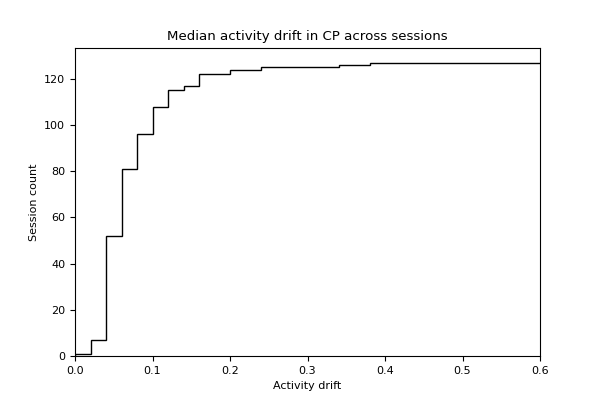

In [118]:
fig,ax=plt.subplots(figsize=(6,4))
ax.hist(drift_by_session['activity_drift'],bins=np.arange(0,1.02,0.02),color='k',cumulative=True,histtype='step')
ax.set_title(f'Median activity drift in {sel_area} across sessions')
ax.set_xlabel('Activity drift')
ax.set_ylabel('Session count')

if sel_area=='MOs':
    sel_sessions=['703880_2024-04-15','742903_2024-10-22','686176_2023-12-07','742903_2024-10-21','664851_2023-11-15'] #MOs
elif sel_area=='VISp':
    sel_sessions=['681532_2023-10-18','733891_2024-09-17','737403_2024-09-24','715710_2024-07-16','733891_2024-09-19'] #VISp
elif sel_area=='MRN':
    sel_sessions=['743199_2024-12-03','741137_2024-10-11','733891_2024-09-18','741137_2024-10-08','712815_2024-05-23'] #MRN
else:
    sel_sessions=[]

    
sel_colors=['r','b','g','c','m']

for ss,session_id in enumerate(sel_sessions):
    drift_value=drift_by_session.query('session_id==@session_id')['activity_drift'].values
    ax.axvline(x=drift_value,color=sel_colors[ss],linestyle='--',
               label=f'{session_id} (median={drift_value})')
    ax.legend(loc='lower right',fontsize=8)
    
ax.set_xlim([0,0.6])

In [99]:
# f'{session_id} (median={drift_by_session.query('session_id==@session_id')['activity_drift']})
# drift_by_session.query('session_id==@session_id')['activity_drift']
# sel_sessions
# drift_value
all_session_decoding=pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\logreg_many_n_units_medium_criteria_2025-01-08\decoder_results_summary.csv")
templeton_sessions=all_session_decoding.query('project.str.contains("Templeton" )')['session_id'].unique()
templeton_sessions

array(['620263_2022-07-26', '620263_2022-07-27', '620264_2022-08-02',
       '628801_2022-09-19', '636397_2022-09-26', '636397_2022-09-27',
       '644547_2022-12-05', '644547_2022-12-06', '646318_2023-01-17',
       '649944_2023-02-27', '649944_2023-02-28', '662983_2023-05-15',
       '668759_2023-07-12', '668759_2023-07-13', '670180_2023-07-26',
       '670180_2023-07-27', '670181_2023-07-18', '670248_2023-08-01'],
      dtype=object)

In [111]:
all_session_decoding.query('project.str.contains("Templeton" )')['area'].unique()

array(['DG', 'CA1', 'VISp', 'TEa', 'VISli', 'VISl', 'LSr', 'IG', 'ACAv',
       'ACAd', 'MOs', 'all', 'MOp', 'MB', 'NB', 'POST', 'RSPd', 'SSs',
       'VISal', 'TTd', 'DP', 'OLF', 'ILA', 'ORBm', 'PL', 'out of brain',
       'SSp', 'RSPagl', 'SUB', 'CP', 'AUDd', 'ORBvl', 'ORBl', 'FRP', 'PO',
       'LP', 'MRN', 'SCig', 'AUDp', 'AUDpo', 'SEZ', 'SCm', 'CA3', 'VISpm',
       'CA2', 'BST', 'VISa', 'VISrl', 'STR', 'LSv', 'TH', 'LGd', 'LA',
       'VAL', 'LD', 'MS', 'AV', 'MGv', 'MGd', 'ProS', 'AON', 'VPM', 'MGm',
       'SGN', 'RT', 'ENTl', 'or', 'BLAp', 'LSc', 'GPe', 'PRE', 'HPF',
       'VISpor'], dtype=object)

In [116]:
all_session_decoding.query('project.str.contains("Templeton") and area=="CP"')['session_id'].unique()

array(['620264_2022-08-02', '636397_2022-09-26', '636397_2022-09-27',
       '644547_2022-12-05', '644547_2022-12-06', '646318_2023-01-17',
       '649944_2023-02-27', '649944_2023-02-28', '662983_2023-05-15',
       '668759_2023-07-12', '670180_2023-07-27', '670181_2023-07-18',
       '670248_2023-08-01'], dtype=object)

In [120]:
# drift_by_session.query('activity_drift<=0.12 and activity_drift>0.08').sort_values(by='activity_drift',ascending=False)
drift_by_session.query('activity_drift<=1 and activity_drift>0 and session_id in @templeton_sessions').sort_values(by='activity_drift',ascending=False)
# drift_by_session

,session_id,date,activity_drift,presence_ratio,isi_violations_ratio,amplitude_cutoff,fraction_sua,fraction_mua,fraction_noise,n_total_units,n_good_blocks,overall_dprime
3,636397_2022-09-26,2022-09-26,0.178296,0.846154,0.000000,0.000501,0.604651,0.375000,0.020349,344,0,NaN
9,644547_2022-12-06,2022-12-06,0.169976,0.822785,0.000000,0.000407,0.555858,0.395095,0.049046,367,0,NaN
18,646318_2023-01-17,2023-01-17,0.129547,0.910256,0.000000,0.000395,0.563694,0.414013,0.022293,314,0,NaN
8,644547_2022-12-05,2022-12-05,0.105738,0.903846,0.000000,0.000461,0.593750,0.398438,0.007812,128,0,NaN
0,620264_2022-08-02,2022-08-02,0.101211,0.984127,0.415524,0.000205,0.189189,0.324324,0.486486,37,0,NaN
24,649944_2023-02-27,2023-02-27,0.099278,0.753247,0.000000,0.000455,0.621849,0.355742,0.022409,357,0,NaN
45,668759_2023-07-12,2023-07-12,0.082848,1.000000,0.005324,0.000246,0.587500,0.287500,0.125000,80,0,NaN
4,636397_2022-09-27,2022-09-27,0.077730,0.936709,0.190913,0.000535,0.401235,0.540123,0.058642,324,0,NaN
30,662983_2023-05-15,2023-05-15,0.072241,1.000000,0.324796,0.000588,0.376471,0.329412,0.294118,85,0,NaN
49,670248_2023-08-01,2023-08-01,0.070471,0.886792,0.000000,0.000389,0.591029,0.360158,0.048813,758,0,NaN


In [54]:
drift_by_session.query('session_id.str.contains("2024-10-22")')

,session_id,date,activity_drift,presence_ratio,isi_violations_ratio,amplitude_cutoff,fraction_sua,fraction_mua,fraction_noise,n_total_units


In [ ]:
# sel_sessions=['703880_2024-04-15','742903_2024-10-22','686176_2023-12-07','664851_2023-11-15','742903_2024-10-21'] #MOs
# sel_sessions_templ=['628801_2022-09-19','620264_2022-08-02','668759_2023-07-12','649944_2023-02-28'] #MOs templeton
# sel_sessions=['681532_2023-10-18','733891_2024-09-17','737403_2024-09-24','715710_2024-07-16','733891_2024-09-19'] #VISp
# sel_sessions_templ=['670180_2023-07-27','644547_2022-12-05','668759_2023-07-13','636397_2022-09-26'] #VISp templeton
# sel_sessions=['743199_2024-12-03','741137_2024-10-11','733891_2024-09-18','741137_2024-10-08','712815_2024-05-23'] #MRN
sel_sessions=[] #CP templeton


In [93]:
all_session_ids=['703880_2024-04-15','742903_2024-10-22','686176_2023-12-07','664851_2023-11-15','742903_2024-10-21',
                 '681532_2023-10-18','733891_2024-09-17','737403_2024-09-24','715710_2024-07-16','733891_2024-09-19',
                 '743199_2024-12-03','741137_2024-10-11','733891_2024-09-18','741137_2024-10-08','712815_2024-05-23']

unique_session_ids = np.unique(np.array(all_session_ids))
unique_session_ids

array(['664851_2023-11-15', '681532_2023-10-18', '686176_2023-12-07',
       '703880_2024-04-15', '712815_2024-05-23', '715710_2024-07-16',
       '733891_2024-09-17', '733891_2024-09-18', '733891_2024-09-19',
       '737403_2024-09-24', '741137_2024-10-08', '741137_2024-10-11',
       '742903_2024-10-21', '742903_2024-10-22', '743199_2024-12-03'],
      dtype='<U17')

In [91]:
for ss in sel_sessions:
    print(ss)
    print(pd.read_parquet(npc_lims.get_cache_path('performance',version='0.0.265',session_id=ss))['cross_modal_dprime'].values)

703880_2024-04-15
[1.73162517 2.68128702 1.01052789 2.34528445 1.51611098 2.36865881]
742903_2024-10-22
[3.50772464 2.76456036 2.29600212 2.99639737 2.92640519 0.76470967]
686176_2023-12-07
[3.13514617 2.85689525 1.69149799 1.8719197  1.3009371  2.4843645 ]
664851_2023-11-15
[2.70264118 2.63445373 3.82269585 2.50396162 3.16662535 2.46233202]
742903_2024-10-21
[3.45595069 1.38053991 3.60481761 1.0301715  3.48272878 2.77665652]


In [15]:
all_units['decoder_label'].value_counts()

decoder_label
sua      334896
mua      214950
noise     32670
Name: count, dtype: int64

Text(0, 0.5, 'Activity drift')

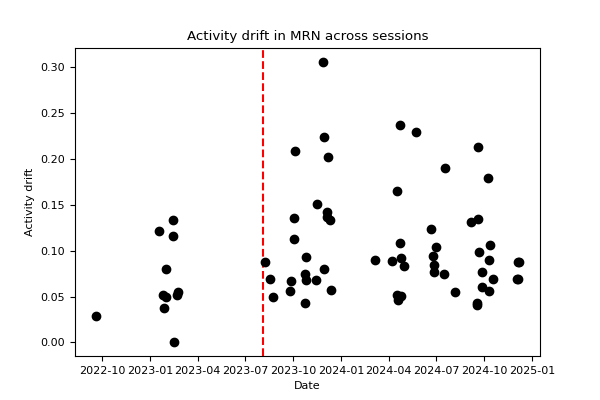

In [69]:
#plot activity drift versus date

date_threshold=dt.datetime.strptime('2023-08-05','%Y-%m-%d').date()

fig,ax=plt.subplots(figsize=(6,4))
ax.axvline(x=date_threshold,color='r',linestyle='--')
ax.plot(drift_by_session['date'],drift_by_session['activity_drift'],'o',color='k')
ax.set_title(f'Activity drift in {sel_area} across sessions')
ax.set_xlabel('Date')
ax.set_ylabel('Activity drift')

In [30]:
"""
'activity_drift', 'amplitude', 'amplitude_cutoff',
'amplitude_cv_median', 'amplitude_cv_range', 'amplitude_median',
'ccf_ap', 'ccf_dv', 'ccf_ml', 'channels', 'cluster_id', 'd_prime',
'decoder_label', 'decoder_probability', 'default_qc', 'drift_mad',
'drift_ptp', 'drift_std', 'electrode_group_name', 'exp_decay',
'firing_range', 'firing_rate', 'half_width', 'is_not_drift',
'isi_violations_count', 'isi_violations_ratio', 'isolation_distance',
'l_ratio', 'location', 'nn_hit_rate', 'nn_miss_rate',
'num_negative_peaks', 'num_positive_peaks', 'num_spikes',
'peak_channel', 'peak_electrode', 'peak_to_valley', 'peak_trough_ratio',
'peak_waveform_index', 'presence_ratio', 'recovery_slope',
'repolarization_slope', 'rp_contamination', 'rp_violations',
'silhouette', 'sliding_rp_violation', 'snr', 'spread', 'structure',
'unit_id', 'velocity_above', 'velocity_below', 'obs_intervals',
'electrodes', 'device_name', 'session_idx', 'date', 'subject_id',
'session_id'
"""

cols_to_keep=['session_id','structure','ccf_ap', 'ccf_dv', 'ccf_ml']

In [31]:
reduced_units=all_units[cols_to_keep]
reduced_units

,session_id,structure,ccf_ap,ccf_dv,ccf_ml
id,,,,,
1414,620263_2022-07-26,ACAd,4650.0,2050.0,5250.0
1663,620263_2022-07-26,ACAd,4650.0,2000.0,5200.0
1664,620263_2022-07-26,ACAd,4650.0,2000.0,5200.0
1665,620263_2022-07-26,ACAd,4650.0,1950.0,5150.0
1666,620263_2022-07-26,ACAd,4600.0,1950.0,5150.0
...,...,...,...,...,...
1151,767172_2024-11-06,None,NaN,NaN,NaN
1152,767172_2024-11-06,None,NaN,NaN,NaN
1153,767172_2024-11-06,None,NaN,NaN,NaN


In [32]:
# reduced_units.to_csv(r'D:\reduced_units_v0.265.csv')

In [33]:
len(all_units.query('session_id=="726088_2024-06-21" and structure=="MOs"'))



82